In [1]:
import pandas as pd

def load_data(filepath="pset1/Iris_Data.txt"):
    data = pd.read_csv(filepath, sep=",", header=None)
    data.columns = ["sepal_length", "sepal_width", 
                    "petal_length", "petal_width", 
                    "class"]
    return data

data = load_data()
print("{} data points loaded".format(len(data)))

150 data points loaded


# 1: Perceptron

## Plot Iris flower dataset

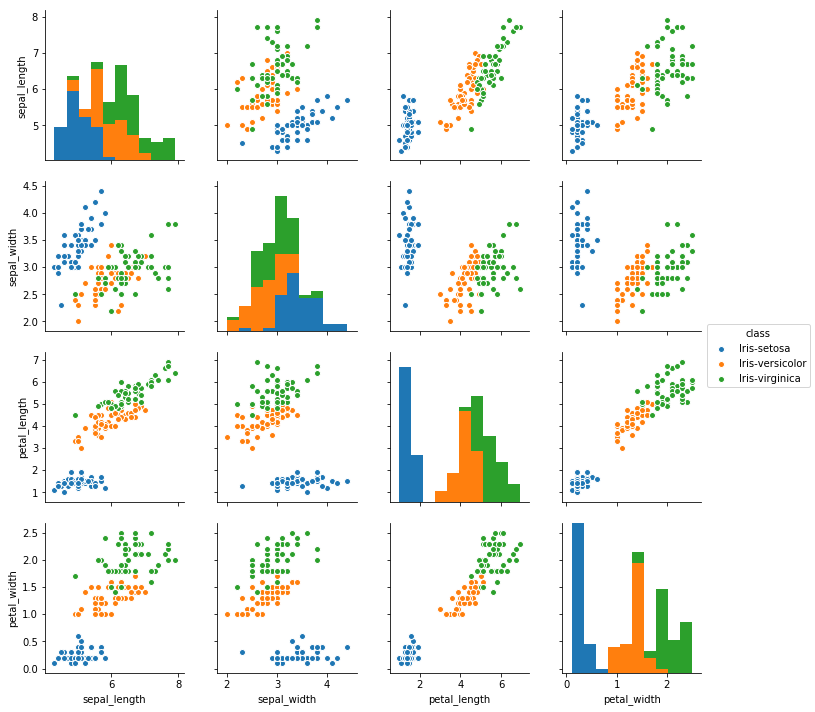

In [2]:
%matplotlib inline
import seaborn
seaborn.pairplot(data, hue='class')

## Perceptron

In [124]:
import numpy as np
import itertools
from enum import Enum, auto


class Perceptron(object):
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs)

    def __call__(self, feature_vector, log=False):
        # y = w * x
        y = sum(self.weights.T * feature_vector)
        if log:
            print("{} * {} = {}".format(self.weights, feature_vector, y))
        return y

    def step(self, feature_vector, target, learning_rate, log=False):
        y = self(feature_vector, log=log)
        self.update_weights(feature_vector, y, target, learning_rate=learning_rate)
        predicted = self.convert_class(y)
        if predicted == target:  # yay
            return True
        if log:
            print("Predicted {}, but was {}".format(predicted, target))
        return False  # nay
    
    def update_weights(self, feature_vector, y, target, learning_rate):
        assert target in [1, 2]
        if self.convert_class(y) == target:
            return
        self.weights = self.weights + learning_rate * feature_vector * (-1 if y > 0 else +1)

    def convert_class(self, y, class1=1, class2=2):
        # y is a confidence value, convert to explicit class
        return class1 if y > 0 else class2
    
    class SamplingStrategy(Enum):
        CYCLE = auto
        RANDOM = auto
        
    def _sampling_generator(self, features, targets, sampling_strategy): 
        if sampling_strategy is Perceptron.SamplingStrategy.CYCLE:
            return zip(itertools.cycle(features), itertools.cycle(targets))
        if sampling_strategy is Perceptron.SamplingStrategy.RANDOM:
            def sample():
                while True:
                    index = np.random.randint(low=0, high=len(features))
                    yield features[index], targets[index]
            return sample()
        raise ValueError()

    def train_steps(self, features, targets,
                    learning_rate=1e-1, num_epochs=10,
                    yield_error_every=10, convert_targets=True, sampling_strategy=SamplingStrategy.CYCLE,
                    log=False):
        assert len(features) == len(targets)
        if convert_targets:
            targets = self._convert_targets(targets, log=log)
        samples = self._sampling_generator(features, targets, sampling_strategy)
        
        errors = 0
        for step, (feature_vector, target) in enumerate(samples, start=1):
            correct = self.step(feature_vector, target, learning_rate=learning_rate, log=log)
            errors = errors + (not correct)
            if step % yield_error_every == 0:
                yield step, errors / yield_error_every
                errors = 0
            if step / len(features) == num_epochs:
                break

    def _convert_targets(self, targets, log=False):
        mapping = {}
        result = []
        for target in targets:
            if target not in mapping:
                assert len(mapping) <= 1, "max of two classes allowed"
                mapping[target] = 1 + (max(mapping.values()) if len(mapping) > 0 else 0)
                if log:
                    print("Mapping {} to {}".format(target, mapping[target]))
            result.append(mapping[target])
        return result


In [129]:
%matplotlib inline
from matplotlib import pyplot

features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
classes = data['class']


def run_classes(class_names,
                model_class=Perceptron,
                num_epochs=10, learning_rate=1e-1,
                yield_error_every=25, log=False, **kwargs):
    index = classes.isin(class_names)
    print("Running {} vs {} ({} features)".format(*class_names, sum(index)))
    _features, _classes = features[index].values, classes[index].values
    model = model_class(4)
    steps_errors = list(model.train_steps(_features, _classes,
                                          num_epochs=num_epochs, learning_rate=learning_rate,
                                          yield_error_every=yield_error_every, log=log, **kwargs))
    pyplot.figure()
    pyplot.plot([step for step, _ in steps_errors], [error * 100 for _, error in steps_errors])
    pyplot.title("{} vs {}".format(*class_names))
    pyplot.xlabel("Steps")
    pyplot.ylabel("Classification error [%]")
    # pyplot.ylim([-1, 10])


### Classification performance for pairwise combination of classes

Running Iris-setosa vs Iris-versicolor (100 features)
Running Iris-setosa vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)


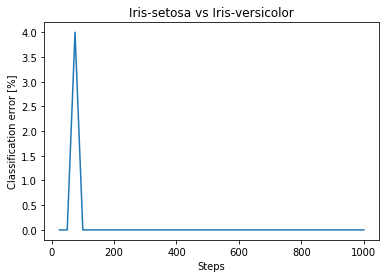

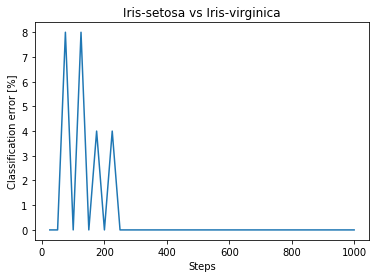

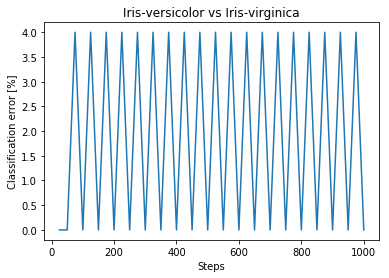

In [128]:
import itertools

for class_combination in itertools.combinations(np.unique(classes), 2):
    run_classes(class_combination)

setosa is linearly separable from the other two classes (perceptron converges).

versicolor and virginica are not linearly separable, the perceptron never converges

### Impact of learning rate

we only consider the two linearly separable classes Iris-setosa and Iris-versicolor.

Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)
Running Iris-versicolor vs Iris-virginica (100 features)


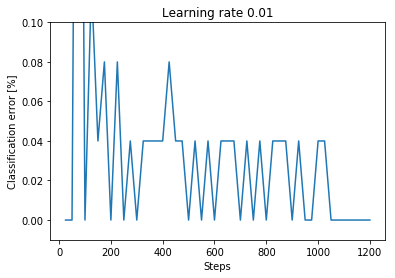

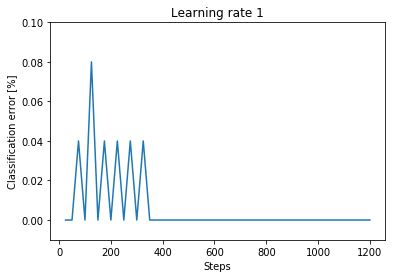

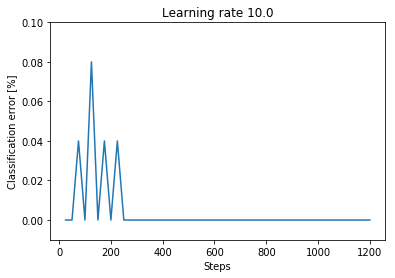

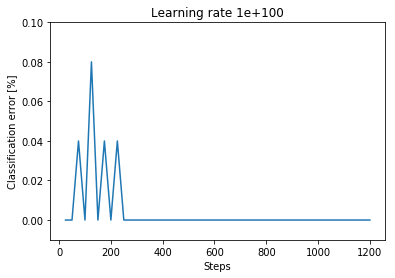

In [6]:
for learning_rate in [1e-2, 1, 1e1, 1e100]:
    run_classes(["Iris-setosa", "Iris-versicolor"], learning_rate=learning_rate, num_epochs=10)
    pyplot.title("Learning rate {}".format(learning_rate))

when the learning rate is too small, it takes a long time to converge because each update is just a tiny nudge in the right direction.

A large learning rate on the other hand leads to faster convergence at the possible price of missing the minima (this did not occur here, I guess we were lucky).

### Absolute correction procedure

Running Iris-setosa vs Iris-versicolor (100 features)


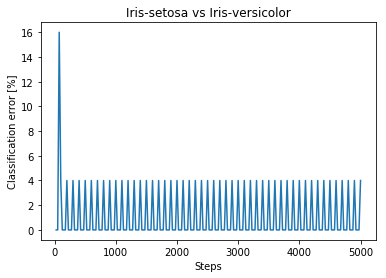

In [135]:
import sys


class AbsoluteCorrectionPerceptron(Perceptron):
    def update_weights(self, feature_vector, y, target, learning_rate):
        # assume we incorrectly classified a sample
        if y > 0:
            # let x=feature_vector, wt=weights_t, wt1=weight_{t+1}, lr = learning_rate
            # our goal is: sum(wt1 * x) < 0
            # = sum((wt + lr * x * -1) * x) < 0
            # = sum(wt * x + lr * x^2 * -1) < 0
            # = sum(wt * x) + sum(lr * x^2 * -1) < 0
            # = lr * -1 * sum(x^2) < sum(-wt * x) [eq]
            # = lr >= -1 * sum(-wt * x) / sum(x^2)
            learning_rate = -1 * sum(-self.weights * feature_vector) / sum(feature_vector * feature_vector)
        else:
            # as above, but with +1 instead of -1. From [eq]:
            # lr * +1 * sum(x^2) < sum(-wt * x)
            # lr < sum(-wt * x) / sum(x^2)
            learning_rate = sum(-self.weights * feature_vector) / sum(
                feature_vector * feature_vector) - sys.float_info.epsilon
        super(AbsoluteCorrectionPerceptron, self).update_weights(feature_vector, y, target, learning_rate=learning_rate)


run_classes(["Iris-setosa", "Iris-versicolor"],
            model_class=AbsoluteCorrectionPerceptron, 
            learning_rate=None, num_epochs=50, sampling_strategy=Perceptron.SamplingStrategy.RANDOM)


The absolute correction procedure will - if it converges - converge much faster.

However, I noticed that there were several cases where it kept bouncing around, misclassifying between 0 and 4% of samples.
I'm guessing that the algorithm tries to shift the weights too hard in one direction and keeps misclassifying some other sample as a consequence. 
Because it always shifts the weights all the way to the decision boundary, it never lands on the sweet spot that it might find if it were using a smaller learning rate.

In the successful runs though, convergence was very fast, and most importantly, I didn't have to optimize for an additional hyper-parameter.
A smarter way of doing this is probably efficiently sampling samples that are right on or very close to the current decision boundary.
I think this also exists and is called something like "boundary maximizing ... / boundary sampling" or so.

# 2: Sanger's & Oja's rule

In [2]:
import itertools
import copy
from collections import deque

import numpy as np


class UnsupervisedNetwork(object):
    def __init__(self, num_inputs, num_outputs):
        self.weights = np.random.rand(num_inputs, num_outputs)

    def __call__(self, feature_vector):
        y = self.weights.T * feature_vector
        y = y.sum(axis=-1)
        # print("{} * {} -> {}".format(self.weights.shape, feature_vector.shape, y.shape))
        return y

    def step(self, feature_vector, learning_rate):
        y = self(feature_vector)
        for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
                weight_change = learning_rate * y[j] * (
                        feature_vector[i] - sum([self.weights[i, k] * y[k]
                                                 for k in range(self.weights.shape[1])]))
                self.weights[i, j] += weight_change
                assert not np.isnan(self.weights[i, j])

    def _weight_delta(self, prev_weights):
        diff = np.abs(self.weights - prev_weights)
        return np.sum(diff, axis=tuple(range(len(self.weights.shape))))

    def train_steps(self, features,
                    learning_rate=1e-1, max_epochs=10,
                    yield_delta_every=10, convergence_area=100):
        weight_deltas = deque(maxlen=convergence_area)
        # for step, feature_vector in enumerate(itertools.cycle(features)):
        for step in itertools.count(start=1):
            feature_vector = features[np.random.choice(len(features))]
            prev_weights = copy.deepcopy(self.weights)
            self.step(feature_vector, learning_rate=learning_rate)
            if step % yield_delta_every == 0:
                weight_delta = self._weight_delta(prev_weights)
                yield step, weight_delta
                weight_deltas.append(weight_delta)
                if sum(weight_deltas) == 0:
                    print("converged at step {}".format(step))
                    break  # converged
            if step / len(features) == max_epochs:
                break


Text(0,0.5,'Weight delta')

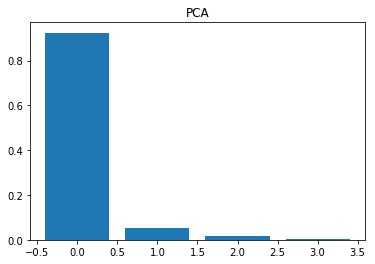

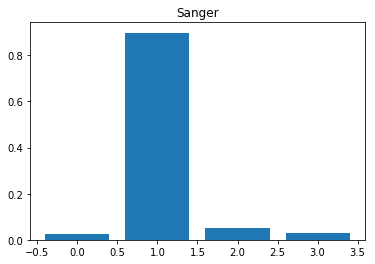

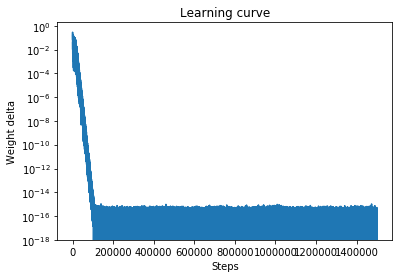

In [8]:
% matplotlib inline
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn import preprocessing

data = load_data()
features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
# features_ = preprocessing.scale(features)  # not actually necessary
features_ = features.values

# features
features_var = np.var(features, axis=0)

def run(title, components, transformed_values):
    np.testing.assert_array_almost_equal(np.linalg.norm(components, axis=0), [1.] * 4)
    components_var = np.var(transformed_values, axis=0)
    np.testing.assert_almost_equal(sum(features_var), sum(components_var))  # same summed variance
    explained_variance = components_var / sum(components_var)

    pyplot.figure()
    pyplot.title(title)
    pyplot.bar(range(len(components)), explained_variance)

pca = PCA().fit(features)
run("PCA", pca.components_, pca.transform(features))

net = UnsupervisedNetwork(*[features.shape[-1]] * 2)
steps_deltas = list(net.train_steps(features_, learning_rate=1e-2, max_epochs=10000))
transformed_values = np.array([net(f) for f in features_])
run("Sanger", net.weights, transformed_values)

pyplot.figure()
pyplot.title("Learning curve")
pyplot.semilogy([step for step, _ in steps_deltas], [delta for _, delta in steps_deltas])
pyplot.xlabel("Steps")
pyplot.ylabel("Weight delta")


The principal components found by Sanger's rule don't have quite as much strength as standard PCA, i.e. the first PC_Sanger explains less variance than the first PC_PCA.
Nonetheless, it's still really cool that this works.
For some runs, it seemed like the PCs weren't as strong though, i.e. the first PC explained even less variance.
It seems like we need quite a lot of epochs (and a small learning rate, otherwise weights will become unbounded!) to get this to work.

# 3: Unsupervised --?--> Supervised

Index(['PC2', 'PC3'], dtype='object')


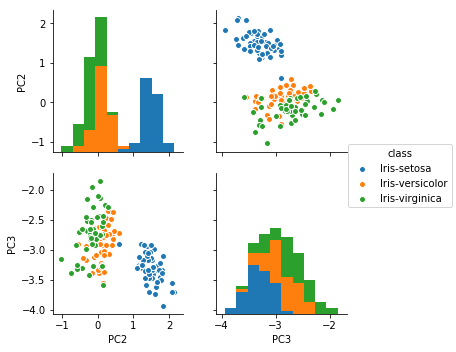

In [32]:
import seaborn

pcs = pd.DataFrame(transformed_values, index=features.index,
                   columns=['PC{}'.format(i) for i in range(features.shape[1])])
explained_variance = np.var(pcs, axis=0)
two_pc_indices = np.argpartition(explained_variance, -2)[-2:]  # unsorted
# two_pc_indices = two_pc_indices[np.argsort(pcs[explained_variance])]  # this would sort it
print(two_pc_indices.index)
pcs = net.weights[two_pc_indices]
pc_transformed_values = np.array([[np.dot(f, pc) for f in features_] for pc in pcs])
pc_transformed_values = pd.DataFrame(pc_transformed_values.T, index=features.index, columns=two_pc_indices.index)
pc_transformed_values['class'] = data['class']
seaborn.pairplot(pc_transformed_values, hue='class')


Iris-setosa is not perfectly linearly separably anymore, one of the points falls inside the other classes (at least judging visually).

PCs are good for supervised learning of linear features in general, because they reduce the dimensionality of your data and thus the weights, and pre-process the data already in a sense.
Due to the reduced number of weights, training is generally faster and might generalize better if the decomposition is right.
However, we can't really apply this to any non-linear problem unfortunately.

I wonder if other concepts from the class could serve as an unsupervised dimensionality reduction in the non-linear regime - perhaps a neural network with non-linearities, trained by Sanger's rule? 
I would be interested to get your input on this.

# 4: Adaline

In [61]:
class Adaline(Perceptron):
    def update_weights(self, feature_vector, y, target, learning_rate):
        assert target in [1, -1], "target {} out of range".format(target)
        self.weights += learning_rate * (target - y) * feature_vector
        
    def convert_class(self, y, class1=1, class2=-1):
        return super(Adaline, self).convert_class(y, class1=class1, class2=class2)

100 data points


/home/martin/miniconda3/envs/9.S52-pset1/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/martin/miniconda3/envs/9.S52-pset1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


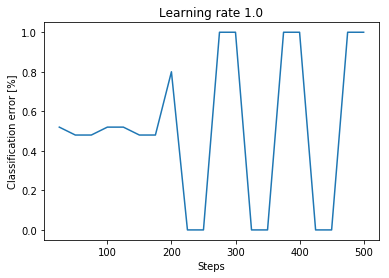

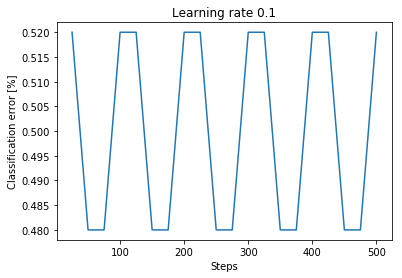

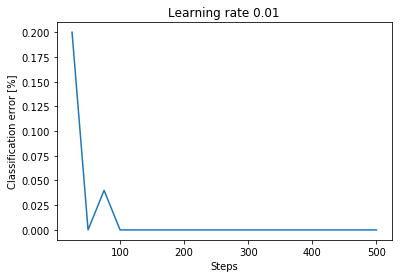

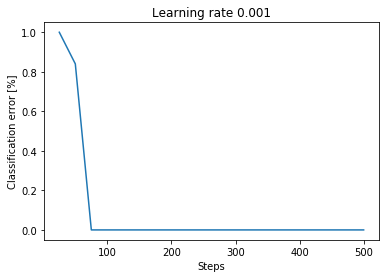

In [62]:
%matplotlib inline
from matplotlib import pyplot

data = load_data("pset1/Iris_Data.txt")
classes = ['Iris-versicolor', 'Iris-setosa']
data = data[data["class"].isin(classes)]
features = data[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
targets = [1 if c == classes[0] else -1 for c in data["class"].values]
print("{} data points".format(len(data)))

for learning_rate in [1e0, 1e-1, 1e-2, 1e-3]:
    model = Adaline(4)
    steps_errors = list(model.train_steps(features.values, targets,
                                          num_epochs=5, learning_rate=learning_rate,
                                          yield_error_every=25, convert_targets=False, log=False))
    pyplot.figure()
    pyplot.title("Learning rate {}".format(learning_rate))
    pyplot.plot([step for step, _ in steps_errors], [error for _, error in steps_errors])
    pyplot.xlabel("Steps")
    pyplot.ylabel("Classification error [%]")


If the learning rate is too large (in this case 0.1 or larger), learning does not converge.
That is because we overshoot the minima with our large step size and never actually land inside the minima.

With smaller learning rates (0.01 or lower in this case) on the other hand, we can approach the minima slower and thus actually land right inside it to converge.

# 5: SOFM Iris

In [25]:
from abc import ABCMeta, abstractmethod

import numpy as np
import itertools

def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

class SOFM(object, metaclass=ABCMeta):
    def __init__(self, num_nodes, num_features):
        self.weights = np.random.rand(num_nodes, num_features)

    @abstractmethod
    def neighborhood(self, i, j):
        raise NotImplementedError()

    def __call__(self, feature_vector):
        best_matching_unit = np.argmin([euclidean_distance(
            feature_vector, self.weights[j]) for j in range(len(self.weights))])
        return best_matching_unit

    def step(self, feature_vector, learning_rate):
        bmu = self(feature_vector)
        for j in range(len(self.weights)):
            delta = learning_rate * self.neighborhood(j, bmu) \
                    * (feature_vector - self.weights[j])
            self.weights[j] += delta

    def train_steps(self, feature_vectors, learning_rate, num_epochs):
        for step, feature_vector in enumerate(itertools.cycle(feature_vectors)):
            self.step(feature_vector, learning_rate)
            if step / len(feature_vectors) == num_epochs:
                break
                

class GaussianSOFM(SOFM):
    def __init__(self, num_nodes, num_features):
        super(GaussianSOFM, self).__init__(num_nodes=num_nodes, num_features=num_features)
        self._neighborhood_radius = 0.5
    
    def neighborhood(self, i, j):
        ri, rj = self.weights[i], self.weights[j]
        distance = euclidean_distance(ri, rj)
        return np.exp(-np.power(distance, 2) /
                      2 * np.power(self._neighborhood_radius, 2))


# 6: SOFM unit square

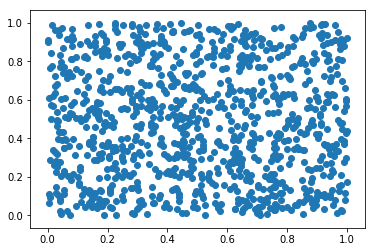

In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

num_points = 1000
data = np.random.uniform(low=0, high=1, size=(num_points, 2))

pyplot.scatter(*data.T)

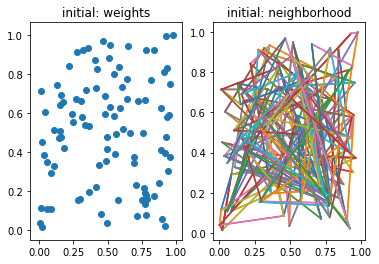

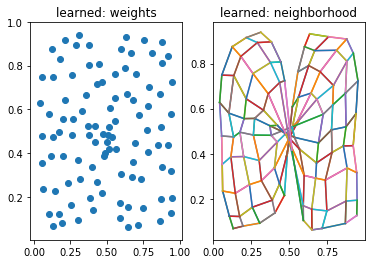

In [34]:
% matplotlib inline
from matplotlib import pyplot


class GridSOFM(SOFM):
    def __init__(self, shape):
        assert len(shape) == 3  # 2D grid * num features
        self.grid_shape = shape[:-1]
        # re-arrange weights for easier access
        super(GridSOFM, self).__init__(num_nodes=np.prod(self.grid_shape), num_features=shape[-1])

    def lattice_location(self, i):
        return np.array(np.unravel_index(i, self.grid_shape))

    def neighborhood(self, i, j):
        ri, rj = self.lattice_location(i), self.lattice_location(j)
        assert len(ri) == len(rj) == 2
        x_dist, y_dist = abs(ri - rj)
        return (x_dist == 0 and y_dist <= 1) or (x_dist <= 1 and y_dist == 0)


s = GridSOFM(shape=(10, 10, 2))

def plot_weights_and_neighborhood(title, weights):
    pyplot.figure()
    
    pyplot.subplot(121)
    pyplot.title('{}: weights'.format(title))
    pyplot.scatter(*weights.T)

    pyplot.subplot(122)
    pyplot.title('{}: neighborhood'.format(title))
    for i, j in itertools.product(list(range(len(s.weights))), repeat=2):
        weight_i, weight_j = weights[i], weights[j]
        if s.neighborhood(i, j) > 0:
            pyplot.plot(*list(zip(weight_i, weight_j)))
    

plot_weights_and_neighborhood("initial", weights=s.weights)

# s.weights[np.ravel_multi_index([9, 9], s.grid_shape)] = (0., 0.75)
s.train_steps(data, learning_rate=1e-1, num_epochs=100)
plot_weights_and_neighborhood("learned", weights=s.weights)


# 7: Circle SOFM

TypeError: plot_weights_and_neighborhood() takes 1 positional argument but 2 were given

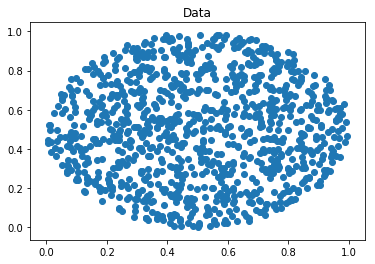

In [35]:
% matplotlib inline
from matplotlib import pyplot
import numpy as np

num_samples = 1000
phi = np.sqrt(np.random.rand(num_samples))
theta = np.random.uniform(low=0, high=2 * np.pi, size=num_samples)
data = np.array([0.5 * (phi * np.cos(theta) + 1), 
                 0.5 * (phi * np.sin(theta) + 1)]).T
pyplot.figure()
pyplot.title("Data")
pyplot.scatter(*data.T)

s = GridSOFM(shape=(10, 10, 2))
s.train_steps(data, learning_rate=1e-1, num_epochs=100)
plot_weights_and_neighborhood("learned circle grid", s.weights)
